In [1]:
import numpy as np
from vpsto.vpsto import VPSTO, VPSTOOptions, VPSTOSolution
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, MultiPolygon, LineString

In [2]:
# # Define some polygons for creating a collision environment
# class CollisionEnvironment():
#     def __init__(self):
#         self.poly_list = []
#         self.poly_list.append(np.array([[0.1, 0.13], [0.23, 0.12], [0.19, 0.28], [0.1, 0.32], [0.16, 0.2]]))
#         self.poly_list.append(np.array([[0.25, 0.34], [0.31, 0.35], [0.32, 0.41], [0.27, 0.44], [0.23, 0.4]]))
#         self.poly_list.append(np.array([[0.35, 0.12], [0.38, 0.1], [0.41, 0.11], [0.42, 0.21], [0.35, 0.24]]))
#         self.multi_poly = MultiPolygon([Polygon(self.poly_list[0]), Polygon(self.poly_list[1]), Polygon(self.poly_list[2])])
        
#     def getTrajDist(self, pts):
#         return self.multi_poly.intersection(LineString(pts)).length

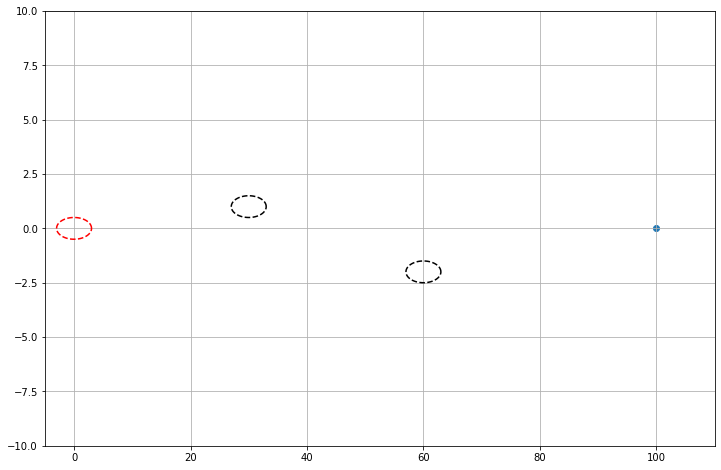

In [3]:
obs_x = [30, 60]
obs_y = [1, -2]

obs_a = 3
obs_b = 0.5

x_init, y_init = [0, 0]
x_final, y_final = [100, 0]

x_lim = [0, 150]
y_lim = [-8, 8]

plt.figure(figsize=(12, 8))

t = np.linspace(0, 2*np.pi, 100)
for i in range(len(obs_x)):
  plt.plot(obs_x[i]+obs_a*np.cos(t) , obs_y[i]+obs_b*np.sin(t) , "--", color="black")

plt.plot(x_init+obs_a*np.cos(t) , y_init+obs_b*np.sin(t) , "--", color="red")
plt.scatter(x_final, y_final)

plt.xlim([-5, 110])
plt.ylim([-10, 10])

plt.grid()
plt.show()

In [4]:
def compute_cumutative_collision_cost(x, y, obs_x, obs_y, obs_a, obs_b):
    obs_x = np.array(obs_x).reshape(len(obs_x), 1)
    obs_y = np.array(obs_y).reshape(len(obs_y), 1)

    # cost_collision = -((x - obs_x[:, np.newaxis])/((2*obs_a)))**2 - ((y - obs_y[:, np.newaxis])/(obs_b))**2 + 1
    cost_collision = np.maximum(np.zeros(x.shape), -((x - obs_x[:, np.newaxis])/((2*obs_a)))**2 - ((y - obs_y[:, np.newaxis])/(2*obs_b))**2 + 1) 
    

    # print(cost_collision.shape)
    cost_collision_combined = np.sum(cost_collision, axis=0)
    # print(cost_collision_combined.shape)
    
    final_cost_collision = cost_collision_combined[0]    

    return final_cost_collision

In [5]:
def compute_collision_loss(candidates):
    costs = []
    for traj in candidates['pos']:
        points_x = traj[:, 0]
        points_y = traj[:, 1]
        
        costs.append(compute_cumutative_collision_cost(points_x,
                                                       points_y,
                                                       obs_x,
                                                       obs_y,
                                                       obs_a, 
                                                       obs_b))
        costs = np.array(costs)
        return costs

In [6]:
# q_min = 0.0*np.ones(2)
# q_max = 0.5*np.ones(2)
q_min = np.array([0, -10])
q_max = np.array([10000, 10])

def loss_limits(candidates):
    q = candidates['pos']
    d_min = np.maximum(np.zeros_like(q), - q + q_min)
    d_max = np.maximum(np.zeros_like(q), q - q_max)
#     return np.sum(d_min > 0.0, axis=(1,2)) + np.sum(d_max > 0.0, axis=(1,2))
    return np.sum(d_min, axis=(1,2)) + np.sum(d_max, axis=(1,2)) 

# env = CollisionEnvironment()
# def loss_collision(candidates): 
#     costs = []
#     for traj in candidates['pos']:
#         costs.append(env.getTrajDist(traj))
#     costs = np.array(costs)
#     costs += costs > 0.0
#     return costs

def collision_loss(candidates):
    costs = []
    for traj in candidates['pos']:
        cost = compute_cumutative_collision_cost(traj[:, 0],
                                            traj[:, 1],
                                            obs_x,
                                            obs_y,
                                            obs_a, 
                                            obs_b) 
    
        cost = np.sum(cost)
    
        costs.append(cost)
    
    costs = np.array(costs)
    return costs

def loss_path_offset(candidates):
    costs = []
    for traj in candidates['pos']:
        cost = np.sum(traj[:, 1]**2)
        costs.append(cost)
    costs = np.array(costs)
    return costs

def loss_curvature(candidates):
    dq = candidates['vel']
    ddq = candidates['acc']
    dq_sq = np.sum(dq**2, axis=-1)
    ddq_sq = np.sum(ddq**2, axis=-1)
    dq_ddq = np.sum(dq*ddq, axis=-1) 
    return np.mean((dq_sq * ddq_sq - dq_ddq**2) / (dq_sq**3 + 1e-6), axis=-1)

def loss(candidates):
    cost_curvature = loss_curvature(candidates)
    print(cost_curvature.shape)
#     cost_collision = loss_collision(candidates)
    cost_collision = collision_loss(candidates)
    print(cost_collision.shape)
    cost_limits = loss_limits(candidates)
    print(cost_limits.shape)
    cost_path_offset = loss_path_offset(candidates)
    print(cost_path_offset)
    return candidates['T'] + \
           1e-3 * cost_curvature + \
           10*1e3 * cost_collision + \
           1e3 * cost_limits + \
           1e-5 * cost_path_offset

In [7]:
opt = VPSTOOptions(ndof=2)
opt.N_via = 3
opt.N_eval = 100
opt.pop_size = 100
opt.log = True
opt.vel_lim = np.array([40.0, 5.0])
opt.acc_lim = np.array([20.0, 5.0])

In [8]:
traj_opt = VPSTO(opt)
traj_opt.ndof = 2

In [9]:
opt.vel_lim

array([40.,  5.])

In [10]:
x_init = 20.0
y_init = 0.0

x_final = 100.0
y_final = 0.0

q0 = np.array([x_init, y_init])
qd = np.array([x_final, y_final])

In [11]:
# q0 = np.array([0.1, 0.2]) # robot position
# qd = np.array([0.4, 0.3])  # desired robot position

In [12]:
# q0 = np.array([0.0, 0.0])
# qd = np.array([100.0, 0.0])

In [13]:
dq0 = np.array([10.0, 0.0])
dqT = np.array([10.0, 0.0])

In [14]:
sol = traj_opt.minimize(loss, q0=q0, qT=qd, dq0=dq0, dqT=dqT)

t_traj = np.linspace(0, sol.T_best, 1000)
# pos, vel, acc = sol.get_trajectory(t_traj)
pos, vel, acc = sol.get_posvelacc(t_traj)

print('Movement duration: ', sol.T_best)

(100,)
(100,)
(100,)
[0.02485749 0.03938836 0.00773894 0.09376387 0.06369991 0.06709534
 0.01088265 0.25010773 0.09151973 0.00259694 0.06213144 0.00972087
 0.0154696  0.00245859 0.02613266 0.04702624 0.00690383 0.04457473
 0.00869966 0.06368482 0.02205083 0.06392295 0.0017162  0.15899641
 0.01001427 0.00409411 0.07920563 0.04107246 0.01543082 0.05049201
 0.0025345  0.15911485 0.0578091  0.06491379 0.00729881 0.02825989
 0.05550061 0.16605596 0.01630107 0.04072674 0.0661839  0.03083493
 0.19089811 0.0626705  0.00403641 0.07616531 0.01583741 0.00434149
 0.156397   0.0041884  0.00864019 0.03858737 0.00279436 0.01781143
 0.26008295 0.01820735 0.06031098 0.09166685 0.02547881 0.03536067
 0.00048813 0.00786955 0.09462778 0.00435934 0.03685686 0.0013927
 0.03915287 0.03924334 0.01360037 0.04929398 0.13552817 0.04442743
 0.01389166 0.09532113 0.12486748 0.00397313 0.14716927 0.04881542
 0.00498237 0.19608686 0.01137779 0.03312062 0.05652183 0.06457399
 0.12511421 0.02617279 0.20242675 0.035044

(100,)
(100,)
(100,)
[13.39173943 13.63764602 13.30576039 19.65192255 21.40492348 20.08695787
 18.62993949 14.7754442  12.14399041 12.41385976 17.30940677 14.36256362
 14.12412562 14.48378331 12.19261178 13.63147633 12.70003996 16.21900261
 11.62895176 18.70776999 15.07459395 15.83529745 14.38456509 15.90679269
 18.43473241 18.44305095 13.36395628 16.43088747 14.86078544 21.40704173
  9.67530585 13.58560449 15.68553653 11.06661204 17.11720483 14.0597177
 14.69188353 14.0381081  22.3324749  15.46427599 14.92895008 15.83961937
 18.1611555  11.77998535 21.74073537 14.42943237 19.93822766 16.82779711
  9.33824829 30.97269585 20.41480333 12.98228658 23.7130726  15.4622648
 18.44434072 19.25345349 15.63152867 16.12817418 14.47014289 15.48340581
 13.32580589  9.55265783 12.66887047 13.2289751  15.46354934 14.64147418
 24.84168619 11.20399195 15.04825529 13.83985049 25.84547098 14.69412784
 16.8922306  10.45970743 14.25576912 18.72159873 22.06284405 18.24781118
 13.14698865  9.91725226 12.9100

(100,)
[0.00945208 0.00177712 0.00404386 0.00124566 0.01319862 0.0119113
 0.00733165 0.00402698 0.04580633 0.00913712 0.00357959 0.00091962
 0.0004691  0.01265774 0.0087488  0.00126529 0.0191387  0.00640235
 0.00918182 0.0075103  0.01145412 0.01123474 0.01762485 0.00691578
 0.00701105 0.0255208  0.00579333 0.00902565 0.0091893  0.02314042
 0.00694918 0.0117733  0.00898409 0.01416864 0.00352709 0.01417259
 0.00290831 0.00544969 0.02467059 0.01153112 0.00774654 0.00303324
 0.00485663 0.01460046 0.00736568 0.00295744 0.0024923  0.01102834
 0.01091877 0.01198005 0.00191183 0.00838555 0.00068303 0.0072367
 0.0017986  0.00780585 0.01164631 0.00402598 0.00071139 0.00477589
 0.01560638 0.01502953 0.00663241 0.01039794 0.00529116 0.00077585
 0.0083761  0.03070301 0.00275297 0.01143411 0.00923471 0.00900485
 0.00191918 0.0039468  0.00097099 0.01234929 0.02056159 0.00103277
 0.00057716 0.00105397 0.00603776 0.00985936 0.01402385 0.00768215
 0.00215466 0.00250762 0.00128622 0.01533081 0.01208928 0

Movement duration:  3.1679368026379975


[]

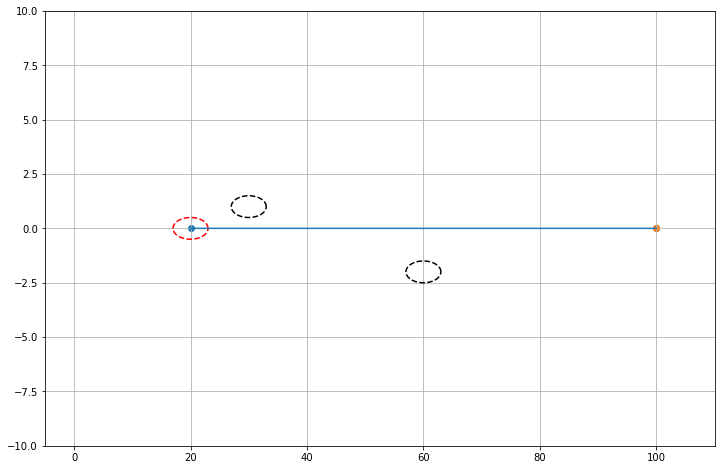

In [15]:
plt.figure(figsize=(12,8))

# plt.xlim([q_min[0], q_max[0]])
# plt.ylim([q_min[1], q_max[1]])
# ax = plt.axes()

plt.scatter([q0[0], qd[0]],[q0[1], qd[1]])
# for pol in env.poly_list:
#     ax.add_patch(patches.Polygon(pol, facecolor = 'gray'))
for i in range(len(obs_x)):
  plt.plot(obs_x[i]+obs_a*np.cos(t) , obs_y[i]+obs_b*np.sin(t) , "--", color="black")

plt.plot(x_init+obs_a*np.cos(t) , y_init+obs_b*np.sin(t) , "--", color="red")
plt.scatter(x_final, y_final)

plt.plot(pos[:,0], pos[:,1])

plt.xlim([-5, 110])
plt.ylim([-10, 10])
plt.grid()
plt.plot()
# plt.tight_layout()

In [16]:
pos

array([[ 2.00000000e+01,  0.00000000e+00],
       [ 2.00318116e+01, -4.54519700e-08],
       [ 2.00638244e+01, -1.81343874e-07],
       ...,
       [ 9.99361756e+01,  3.86585566e-07],
       [ 9.99681884e+01,  9.68396677e-08],
       [ 1.00000000e+02, -2.60917272e-18]])

In [17]:
vel

array([[ 1.00000000e+01, -2.28543791e-18],
       [ 1.00634222e+01, -2.86297222e-05],
       [ 1.01268443e+01, -5.70399597e-05],
       ...,
       [ 1.01268443e+01, -1.21664879e-04],
       [ 1.00634222e+01, -6.10152870e-05],
       [ 1.00000000e+01,  1.20998122e-19]])

In [18]:
acc

array([[ 2.00000000e+01, -9.06290966e-03],
       [ 2.00000000e+01, -8.99369578e-03],
       [ 2.00000000e+01, -8.92448191e-03],
       ...,
       [-2.00000000e+01,  1.90680186e-02],
       [-2.00000000e+01,  1.91833395e-02],
       [-2.00000000e+01,  1.92986603e-02]])

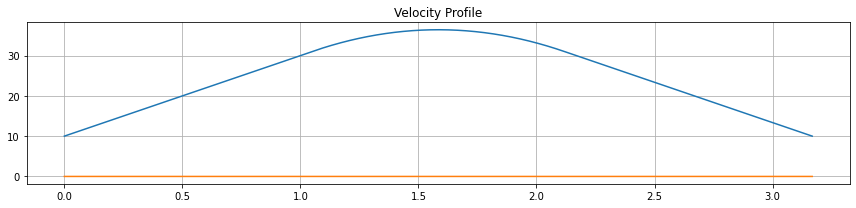

In [19]:
plt.figure(figsize=(12, 3))
plt.grid()
plt.title('Velocity Profile')
plt.plot(t_traj, vel)
plt.tight_layout()

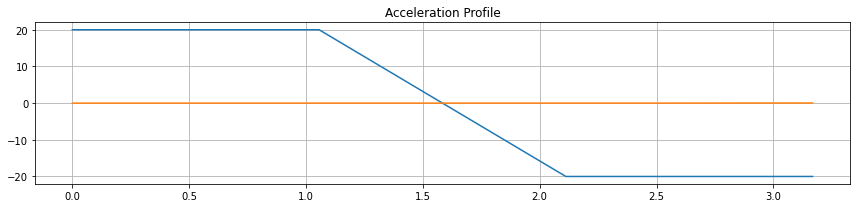

In [20]:
plt.figure(figsize=(12, 3))
plt.grid()
plt.title('Acceleration Profile')
plt.plot(t_traj, acc)
plt.tight_layout()